In [21]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, precision_recall_fscore_support, precision_recall_curve
import pandas as pd

In [2]:
# M stands for both Male and Misdemeanor
def is_M(char):
    if char == "M":
        return 1
    else:
        return 0

In [3]:
def clean_data(df):
    # Dropping Lattitude, Longitude, 
    # Y_coord, X_coord, new Georeferenced, 
    # Jurisdiction code, and precinct columns
    # (all of these are descriptions of geographic location)
    
    # We would train the model to correlate arrest 
    # precincts with the boroughs over which they have jurisdiction (most of the time)
    df = df.drop(columns=['ARREST_PRECINCT', 'JURISDICTION_CODE',\
        'X_COORD_CD', 'Y_COORD_CD', 'Latitude', 'Longitude',\
        'New Georeferenced Column', 'LAW_CODE', 'PD_CD', 'KY_CD'])
    
    ys = df['ARREST_BORO']
    xs = df.drop(columns=['ARREST_BORO'])
    
    # https://www.grepper.com/answers/289320/how+to+convert+data+type+of+a+column+in+pandas?ucard=1
    xs['ARREST_DATE'] = xs['ARREST_DATE'].apply(lambda x: x.replace('/',''))
    # Listing and shuffling police descriptions so that order is not important
    pd_descriptions = np.unique(xs['PD_DESC'])
    random.shuffle(pd_descriptions)
    
    # Listing and shuffling police descriptions so that order is not important
    OF_descriptions = np.unique(xs['OFNS_DESC'])
    random.shuffle(OF_descriptions)
    
    race_descriptions =np.unique(xs['PERP_RACE'])
    random.shuffle(race_descriptions)
    
    age_descriptions =np.unique(xs['AGE_GROUP'])
    random.shuffle(age_descriptions)
    
    xs['PD_DESC']   = xs['PD_DESC'].apply(lambda x: np.where(pd_descriptions == x)[0])
    xs['OFNS_DESC'] = xs['OFNS_DESC'].apply(lambda x: np.where(OF_descriptions == x)[0])
    xs['PERP_RACE'] = xs['PERP_RACE'].apply(lambda x: np.where(race_descriptions == x)[0])
    xs['AGE_GROUP'] = xs['AGE_GROUP'].apply(lambda x: np.where(age_descriptions == x)[0])
    # This is not me being sexist, I had to turn sexes into numbers (I'm sorry)
    xs['PERP_SEX']  = xs['PERP_SEX'].apply(lambda x: is_M(x))
    xs['LAW_CAT_CD']  = xs['LAW_CAT_CD'].apply(lambda x: is_M(x))
    return xs, ys

In [5]:
df = pd.read_csv(r"C:\Users\codyt\dev\python_venvs\Grad_School_venv\Grad-School-Work\620-Data-Science-and-Analytics\Project\Arrest_Data.csv")
xs, ys = clean_data(df)
# Why 42? Because it is the answer to life, the universe, and everything
X_train, X_test, Y_train, Y_test = train_test_split(xs, ys, test_size=0.2, random_state=42)
X_train = np.array(X_train)
X_test  = np.array(X_test)
Y_train = np.array(Y_train)
Y_test  = np.array(Y_test)

In [6]:
# This code was used to produce an output of table 1
# This section is at least N^3,
# Incredibly slow, 
# but then again, it is comparing up to 100 max_depths
# For 16 values for k_folds
# Currently running one value for the sake of time as an example
MIN_FOLDS = 5
MAX_FOLDS = 10
MAX_DEPTH = 50
fold_results = []
# Looping from 4 to 15 values for k-folds
for folds in range(MIN_FOLDS, MAX_FOLDS + 1):
    kf = KFold(n_splits=folds)
    error_rates = np.zeros((folds, MAX_DEPTH - 1))
    # Loop over all of the hyperparameter options for max_depth
    for max_depth in range(1, MAX_DEPTH):
        k = 0
        # Evaluate each one K-times
        for train_index, val_index in kf.split(X_train):
            X_tr, X_val = X_train[train_index], X_train[val_index]
            y_tr, y_val = Y_train[train_index], Y_train[val_index]
            tree = DecisionTreeClassifier(max_depth=max_depth)
            tree.fit(X_tr, y_tr)

            y_val_predict = tree.predict(X_val)
            error_rates[k, max_depth-1] = 1 - np.sum(y_val == y_val_predict) / y_val.size
            k += 1

    # Average across the k folds
    error_rates_avg = np.mean(error_rates, axis=0)
    error_rates_cpy = np.array(error_rates_avg)


    min_indeces = np.argsort(error_rates_cpy)[:5]
    min_vals    = [(error_rates_avg[index] * 100) for index in min_indeces]

    plt.plot(np.arange(1, MAX_DEPTH), error_rates_avg)
    plt.title("Max Depth vs error rate (K_Folds = " + str(folds) + ")")
    plt.xlabel('max depth', fontsize=16)
    plt.ylabel('Error Rate(%)',fontsize=16)
    fold_results.append([folds, min_indeces+1, min_vals])
    plt.savefig('Max_depth vs error rate(K_Folds = ' + str(folds) + ')')
    plt.clf()

<Figure size 640x480 with 0 Axes>

In [7]:
for fold_set in fold_results:
        print(f"Number of Folds: {fold_set[0]}")
        for i, elem in enumerate(fold_set[1]):
            print("\t" + str(i + 1) + ". Max_Depth: " + str(elem) + " Error rate: " + str("{:.2f}".format(fold_set[2][i])) + "%")

Number of Folds: 5
	1. Max_Depth: 46 Error rate: 62.13%
	2. Max_Depth: 47 Error rate: 62.14%
	3. Max_Depth: 36 Error rate: 62.17%
	4. Max_Depth: 45 Error rate: 62.17%
	5. Max_Depth: 40 Error rate: 62.17%
Number of Folds: 6
	1. Max_Depth: 43 Error rate: 61.98%
	2. Max_Depth: 46 Error rate: 62.00%
	3. Max_Depth: 48 Error rate: 62.01%
	4. Max_Depth: 38 Error rate: 62.02%
	5. Max_Depth: 40 Error rate: 62.02%
Number of Folds: 7
	1. Max_Depth: 45 Error rate: 61.73%
	2. Max_Depth: 44 Error rate: 61.74%
	3. Max_Depth: 40 Error rate: 61.75%
	4. Max_Depth: 48 Error rate: 61.76%
	5. Max_Depth: 38 Error rate: 61.77%
Number of Folds: 8
	1. Max_Depth: 45 Error rate: 61.70%
	2. Max_Depth: 39 Error rate: 61.70%
	3. Max_Depth: 44 Error rate: 61.71%
	4. Max_Depth: 34 Error rate: 61.71%
	5. Max_Depth: 48 Error rate: 61.71%
Number of Folds: 9
	1. Max_Depth: 46 Error rate: 61.50%
	2. Max_Depth: 41 Error rate: 61.52%
	3. Max_Depth: 44 Error rate: 61.53%
	4. Max_Depth: 47 Error rate: 61.53%
	5. Max_Depth: 39

In [9]:
uniq_depths = [5, 10 , 15, 20, 25, 46, 38, 40]
for depth in uniq_depths:
    test_tree = DecisionTreeClassifier(max_depth=depth)
    test_tree.fit(X_train, Y_train)
    denom = Y_test.size

    Y_pred = test_tree.predict(X_test)
    correct = 0
    for i in range(len(Y_test)):
        if Y_pred[i] == Y_test[i]:
            correct+=1
    success_rate = (correct/denom)
    print(f"Depth = {depth} \tError rate {(1-success_rate) * 100:.5f}%")

Depth = 5 	Error rate 65.34876%
Depth = 10 	Error rate 62.67548%
Depth = 15 	Error rate 62.15096%
Depth = 20 	Error rate 62.02755%
Depth = 25 	Error rate 62.04298%
Depth = 46 	Error rate 61.32893%
Depth = 38 	Error rate 61.22755%
Depth = 40 	Error rate 61.26501%


In [11]:
print(np.unique(Y_test))

['Bronx' 'Brooklyn' 'Manhattan' 'Queens' 'Staten Island']


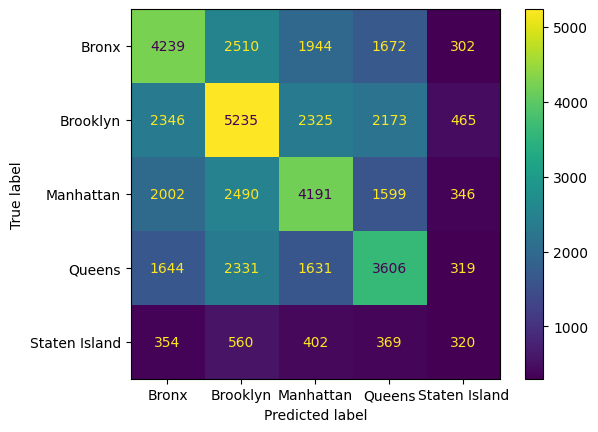

In [15]:
# Optimal hyperparameters
# Max_depth = 38
groups = ['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island']
optimal_depth = 38
# Constructing, Fitting, and predicting with the tree
confusion_matrix_tree = DecisionTreeClassifier(max_depth=optimal_depth)
confusion_matrix_tree.fit(X_train, Y_train)
Y_pred = confusion_matrix_tree.predict(X_test)

matrix      = confusion_matrix(Y_test, Y_pred)
matr_plot   = ConfusionMatrixDisplay(matrix, display_labels=groups)
m = matr_plot.plot()


Average precision across all categories is  0.35283996872679224


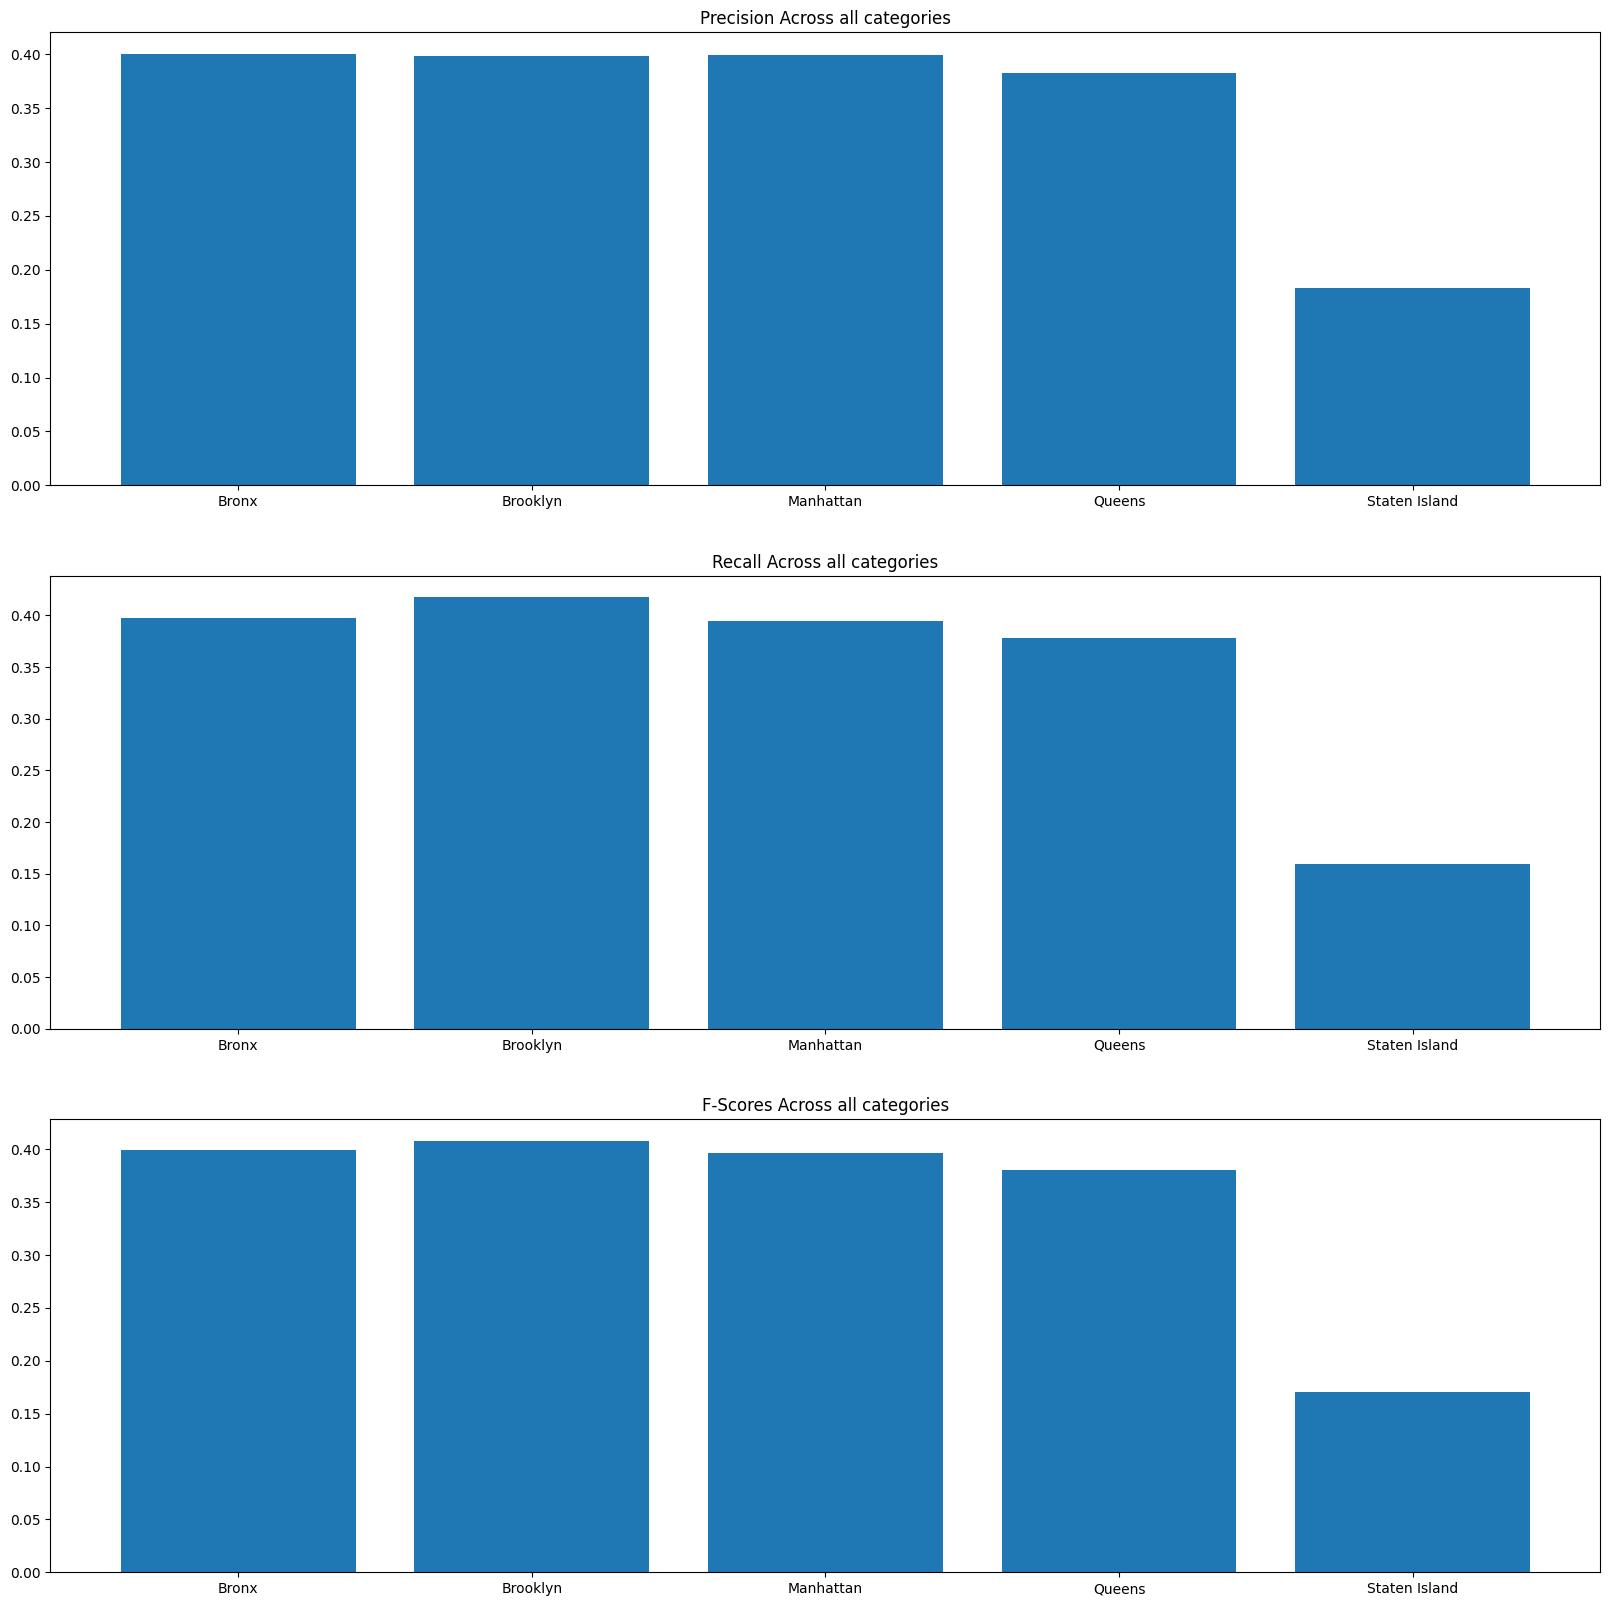

In [31]:
A = precision_recall_fscore_support(Y_test, Y_pred)
precisions  = A[0]
recalls     = A[1]
fscores     = A[2]
fig, axs = plt.subplots(3)
axs[0].bar(x=groups, height=precisions)
axs[0].title.set_text('Precision Across all categories')
axs[1].bar(x=groups, height=recalls)
axs[1].title.set_text('Recall Across all categories')
axs[2].bar(x=groups, height=fscores)
axs[2].title.set_text('F-Scores Across all categories')
fig.set_figwidth(20)
fig.set_figheight(20)

print('Average precision across all categories is ', sum(precisions)/len(precisions) )